In [2]:
from ultralytics import YOLO
from PIL import Image
import numpy as np
import cv2
import supervision as sv
import easyocr
reader = easyocr.Reader(['en'], recognizer=False)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [3]:
"""
YOLO-obb-small model trained on synthetic data on Google Colab runtime
"""
model = YOLO("../models/yolo-obb-s-100ep.pt")

In [4]:
def crop_license_plate(img):
    """
    Runs the YOLO model on the input image and crops the license plate

    Returns:
    - Image: the cropped license plate
    """
    results = model(img)

    detections = sv.Detections.from_ultralytics(results[0])
    xyxyxyxy = detections[0].data['xyxyxyxy'][0]

    point1, point2, point3, point4 = xyxyxyxy
    box_points = [point3, point2, point1, point4]

    if box_points[0][0] > box_points[1][0]:
        box_points = [point1, point4, point3, point2]

    # make blank image of size 520x110
    blank_image = np.zeros((110, 520, 3), np.uint8)
    blank_image[:] = (255, 255, 255)

    # warp
    matrix = cv2.getPerspectiveTransform(np.array(box_points, dtype=np.float32), np.array([[0, 0], [520, 0], [520, 110], [0, 110]], dtype=np.float32))
    warped = cv2.warpPerspective(cv2.imread(img), matrix, (520, 110))

    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    warped = Image.fromarray(warped)
    return warped

In [5]:
def detect_text(img):
    """
    Detects text boxes in the input image

    Returns:
    - list: list of bounding boxes of the detected text
    """
    img = np.array(img)
    result = reader.detect(img, add_margin=0, slope_ths=0)[1][0]
    return result

def find_largest_text_area(results):
    """
    Finds the largest text area in the input image

    Returns:
    - list: list of bounding boxes of the largest text area
    """
    max_width = 0
    max_width_box = None
    for box in results:
        width = box[1][0] - box[0][0]
        if width > max_width:
            max_width = width
            max_width_box = box

    return max_width_box

def find_largest_text_area(results):
    """
    Finds the largest text area in the input image

    Returns:
    - list: list of bounding boxes of the largest text area
    """
    max_width = 0
    max_width_box = None
    for box in results:
        width = box[1][0] - box[0][0]
        if width > max_width:
            max_width = width
            max_width_box = box

    return max_width_box

def extract_box(img, result):
    """
    Extracts the bounding box of the detected text

    Returns:
    - Image: the cropped text box
    """
    p1, p2, p3, p4 = result
    box_points = [p1, p2, p3, p4]

    # make blank image of size 520x110
    size = (510, 110)
    blank_image = np.zeros((size[0], size[1], 3), np.uint8)
    blank_image[:] = (255, 255, 255)

    # warp
    matrix = cv2.getPerspectiveTransform(np.array(box_points, dtype=np.float32), np.array([[0, 0], [size[0], 0], [size[0], size[1]], [0, size[1]]], dtype=np.float32))
    warped = cv2.warpPerspective(img, matrix, (size[0], size[1]))

    warped = Image.fromarray(warped)

    return warped


In [6]:
def thresholding(img):
    """
    Applies thresholding to the input image
    """
    img.save("temp.jpg")
    img = cv2.imread("temp.jpg", cv2.IMREAD_GRAYSCALE)

    
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    _, im_gray_th_otsu = cv2.threshold(closing, 128, 192, cv2.THRESH_OTSU)

    _, im_gray_th = cv2.threshold(im_gray_th_otsu, 128, 255, cv2.THRESH_BINARY)

    im_gray_th = cv2.bitwise_not(im_gray_th)

    return Image.fromarray(im_gray_th)


image 1/1 /home/mees/Desktop/UVA/Scriptie/License-Plate-Recognition-Thesis/ALPR/../test_notebooks/images/11.jpg: 640x480 407.6ms
Speed: 3.8ms preprocess, 407.6ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 480)


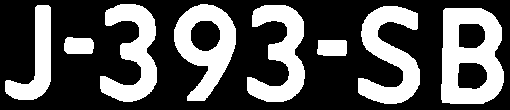

In [19]:
def get_binary_lp_cutout(path_to_img):
    """
    Returns a binary image of the license plate cutout
    """
    cropped = crop_license_plate(path_to_img)
    result = detect_text(cropped)
    result = find_largest_text_area(result)

    return thresholding(extract_box(np.array(cropped), result))

get_binary_lp_cutout("../test_notebooks/images/11.jpg")

# CHARACHTER SEGMENATION

In [20]:
img = get_binary_lp_cutout("../test_notebooks/images/11.jpg")



img_bgr = cv2.cvtColor(np.array(img), cv2.COLOR_GRAY2BGR)

import functools
# Find contours and get bounding box for each contour
cnts, _ = cv2.findContours(np.array(img), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boundingBoxes = [cv2.boundingRect(c) for c in cnts]

# Keep 8 largest bounding boxes by area
boundingBoxes = sorted(boundingBoxes, key=lambda x: x[2]*x[3], reverse=True)[:8]

# Sort the bounding boxes from left to right, top to bottom
# sort by Y first, and then sort by X if Ys are similar
def compare(rect1, rect2):
    if abs(rect1[1] - rect2[1]) > 10:
        return rect1[1] - rect2[1]
    else:
        return rect1[0] - rect2[0]
boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare))

# Draw bounding boxes
for box in boundingBoxes:
    x, y, w, h = box
    cv2.rectangle(img_bgr, (x, y), (x+w, y+h), (0, 255, 0), 2)

# save image with bounding boxes
cv2.imwrite("bounding_boxes.jpg", img_bgr)

image 1/1 /home/mees/Desktop/UVA/Scriptie/License-Plate-Recognition-Thesis/ALPR/../test_notebooks/images/11.jpg: 640x480 436.8ms
Speed: 4.9ms preprocess, 436.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)


True